## Imports ##

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import os
import csv
import pandas as pd
import numpy as np
import math
import datetime
from numpy import linalg



# Models
from surprise import KNNBaseline, BaselineOnly
from surprise import SVD, SVDpp, NMF, SlopeOne, CoClustering


from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import Reader
import matplotlib.pyplot as plt
import pickle

In [19]:
def plot(errors, names=[]):
    
    for error in errors:
        x, y = zip(*error)    
        plt.plot(np.array(x), np.array(y), 'o-')
    
    plt.legend(names, loc='upper left')
    plt.ylabel('RMSE')
    plt.xlabel('n factors')

    plt.show()
    

def save(liste, name="errors"):
    with open(name, 'wb') as fp:
        pickle.dump(liste, fp)

def read(name="errors"):
    with open (name, 'rb') as fp:
        return pickle.load(fp)
    
def create_submission(algo):
    data = Dataset.load_from_df(df[['people', 'movies', 'Prediction']], reader)
    trainset = data.build_full_trainset()
    algo.fit(trainset)
    submission = toPredict[['people', 'movies', 'Prediction']].values.tolist()
    submission_pred = algo.test(submission)
    data = {'Id': ['r' + str(submission_pred[0].iid) + '_c' + str(submission_pred[0].uid)], 'Prediction': [str(submission_pred[0].est)]}
    for i in range(1, len(submission_pred)):
        data['Id'].append('r{0}_c{1}'.format(toPredict.movies[i], toPredict.people[i]))
        data['Prediction'].append(str(submission_pred[i].est))
    
    submission_df = pd.DataFrame(data).rename(columns={0 : 'Id', 1 : 'Prediction'})    
    submission_df.Prediction = [round(float(val)) for val in submission_df.Prediction.values]
    submission_df.to_csv(relative_path + '/submission.csv')
    
def submission_nn(model):
#     submission = toPredict[['people', 'movies', 'Prediction']].values.tolist()
    peoples, movies, _ = list(map(list, zip(*submission)))

    grades = [max(min(c[0], 5), 1) for c in np.round(model.predict([peoples, movies]),0)]
#     grades = [min(int(c[0]*5)+1, 5) for c in model.predict([toPredict.people, toPredict.movies])]

    data = {'Id': [], 'Prediction': []}
    for i in range(len(grades)):
        data['Id'].append('r{0}_c{1}'.format(movies[i], peoples[i]))
        data['Prediction'].append(str(grades[i]))

    submission_df = pd.DataFrame(data).rename(columns={0 : 'Id', 1 : 'Prediction'}).set_index("Id")    
    submission_df.Prediction = [round(float(val)) for val in submission_df.Prediction.values]
    submission_df.to_csv(relative_path + '/submission.csv')
    return submission_df

In [3]:
submission = toPredict[['people', 'movies', 'Prediction']].values.tolist()
peoples, movies, _ = list(map(list, zip(*submission)))

grades = [c[0] for c in np.round(model.predict([peoples, movies]),0)]

data = {'Id': [], 'Prediction': []}
for i in range(len(submission_pred)):
    data['Id'].append('r{0}_c{1}'.format(movies[i], peoples[i]))
    data['Prediction'].append(str(grades[i]))

submission_df = pd.DataFrame(data).rename(columns={0 : 'Id', 1 : 'Prediction'})    
submission_df.Prediction = [round(float(val)) for val in submission_df.Prediction.values]
submission_df

NameError: name 'toPredict' is not defined

In [100]:
submission_df.set_index("Id").Prediction.max()

7

In [99]:
submission_df.set_index("Id").to_csv(relative_path + '/submission.csv')

## Importing and formating ##

In [4]:
relative_path = os.getcwd() + "/data"

df = pd.read_csv(relative_path + '/data_train.csv').set_index("Id")
movies, people = zip(*[tuple(int(x[1:]) for x in x.split("_")) for x in df.index.values])
df["movies"] = movies
df["people"] = people
df = df.reset_index().drop(columns=["Id"])

predictions = pd.read_csv(relative_path + '/sample_submission.csv').set_index("Id")
toPredict = predictions.copy()
movies, people = zip(*[tuple(int(x[1:]) for x in x.split("_")) for x in toPredict.index.values])
toPredict["movies"] = movies
toPredict["people"] = people
toPredict = toPredict.reset_index().drop(columns=["Id"])

# Initializing Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['people', 'movies', 'Prediction']], reader)

#Parameters testing
factors = np.linspace(50, 175, num = 6)
learning_rates = np.linspace(0.05 , 0.2, num = 7)
regularization_rates = np.linspace(0.0025, 0.01, num = 7)

In [5]:
# Nombre moyen de movies par people
tmp = df.groupby(df.people).count()
res = sum(tmp.movies.values)/tmp.count()[0]
print("En moyenne, on a {} movies per people".format(res))

# Nombre moyen de movies par people
tmp = df.groupby(df.movies).count()
res = sum(tmp.people.values)/tmp.count()[0]
print("En moyenne, on a {} people per movie".format(res))

print("{0} movies and {1} users".format(len(df.movies.unique()), len(df.people.unique()))) 

En moyenne, on a 1176.952 movies per people
En moyenne, on a 117.6952 people per movie
10000 movies and 1000 users


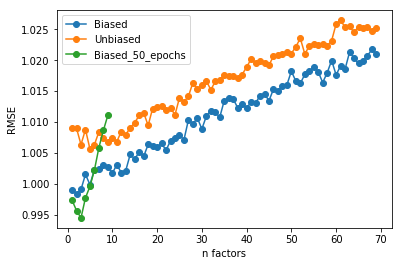

In [6]:
names = ["Biased", "Unbiased", "Biased_50_epochs"]
errors = [read(name) for name in names]
plot(errors, names)

## Training ##

In [13]:
data_s = []

#Besoin d'essayer n_echos?
for factor in range(10, 21, 1):
    print(factor)
    print(datetime.datetime.now())
#     for learning_rate in learning_rates:
#         for regularization_rate in regularization_rates:    

    algo = SVD(n_factors=int(factor), n_epochs=100, lr_all=int(regularization_rate))
    test_rmse = cross_validate(algo, data, measures=['RMSE'], verbose=True)["test_rmse"]
    my_accuracy = sum(test_rmse)/len(test_rmse)            
    data_s.append((factor, my_accuracy))
    
plot([data_s])

10
2018-12-19 14:51:34.254160


NameError: name 'regularization_rate' is not defined

In [ ]:
# data_s = []

#Besoin d'essayer n_echos?
for factor in range(2, 21, 1):
    print(factor)
    print(datetime.datetime.now())
    for learning_rate in learning_rates:
        for regularization_rate in regularization_rates:

            algo = SVD(n_factors=int(factor), lr_all= int(learning_rate), reg_all=int(regularization_rate))
            test_rmse = cross_validate(algo, data, measures=['RMSE'], cv=5)["test_rmse"]
            my_accuracy = sum(test_rmse)/len(test_rmse)
            print("acc: {}".format(my_accuracy))
            data_s.append((factor, my_accuracy))

In [ ]:
# save(data_s, "grid_search")

In [ ]:
400 60 0.001667 0.1

## Grid Search on every model

In [14]:
SVD_param_grid = {'n_epochs': [385, 390],
                  'n_factors': [60],
                  'lr_all': [0.0017, 0.0016, 0.0015],
                  'reg_all': [0.1]}

NMF_param_grid = {'n_epochs': [100, 150],  
                  'n_factors': [10, 15, 20]}

KNNBaseline_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [30, 50, 70],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False, True]}
              }

CoClustering_param_grid = {'n_cltr_u': [3, 4, 5],  
                  'n_cltr_i': [3, 4, 5], 
                 'n_epochs': [25, 50, 100]}


models2 = [(SVD, SVD_param_grid), (NMF, NMF_param_grid), (SlopeOne, {}), 
           (KNNBaseline, KNNBaseline_param_grid), (CoClustering, CoClustering_param_grid)]

In [15]:
all_dfs = []

for (algo, param_grid) in models2[:1]:
    
    print("Testing {}".format(algo))
    gs = GridSearchCV(algo, param_grid, measures=['rmse'], cv=5, joblib_verbose=4, n_jobs=-1)
    gs.fit(data)

    # best RMSE score
    print(gs.best_score['rmse'])

    # combination of parameters that gave the best RMSE score
    print(gs.best_params['rmse'])
    
    # Saving all data into a df
    results_df = pd.DataFrame.from_dict(gs.cv_results)
    results_df.to_csv("GRID_SEARCH_{}12".format(algo))
    all_dfs.append((algo, results_df))

Testing <class 'surprise.prediction_algorithms.matrix_factorization.SVD'>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed: 66.2min remaining: 66.2min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 73.1min remaining: 22.3min


0.9852869589090693
{'n_epochs': 390, 'n_factors': 60, 'lr_all': 0.0017, 'reg_all': 0.1}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 82.6min finished


In [35]:
other = pd.read_csv("grid/GRID_SEARCH_{}".format(KNNBaseline)).sort_values("rank_test_rmse")[relevant_columns]
other.head(3)

,mean_test_rmse,std_test_rmse,rank_test_rmse
33,0.994666,0.001971,1
9,0.994666,0.001971,2
35,0.994730,0.001971,3


In [ ]:
1.006929 : Coclustering
1.005606 : NMF  
0.994666 : KNN
0.984953 : SVD

In [26]:
relevant_columns = ["mean_test_rmse", 'std_test_rmse', "rank_test_rmse"]
svd_params = ["param_n_epochs", "param_n_factors", "param_lr_all", "param_reg_all"]

other = pd.read_csv("grid/GRID_SEARCH_{}12".format(SVD)).sort_values("rank_test_rmse")[relevant_columns+svd_params]
other.head(3)
# 0.986317	0.001530

# 0.986613	0.000168

# 0.984953 

,mean_test_rmse,std_test_rmse,rank_test_rmse,param_n_epochs,param_n_factors,param_lr_all,param_reg_all
0,0.984953,0.001148,1,400,60,0.001667,0.1
1,0.985318,0.001053,2,600,60,0.001667,0.1
2,0.985436,0.001084,3,400,60,0.002500,0.1


In [22]:
algo = SVD(n_epochs=390, n_factors= 60, lr_all= 0.0016, reg_all= 0.1, verbose=True)

In [23]:
from datetime import datetime
print(datetime.now())
create_submission(algo)

2018-12-20 11:10:14.006665
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Pro

### Neural Netowork

In [23]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import keras
from IPython.display import SVG
from keras.optimizers import Adam
# from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import mean_absolute_error
from keras.regularizers import l2

Using TensorFlow backend.


In [24]:
relative_path = os.getcwd() + "/data"

dataset = pd.read_csv(relative_path + '/data_train.csv').set_index("Id")
movies, people = zip(*[tuple(int(x[1:]) for x in x.split("_")) for x in dataset.index.values])
dataset["item_id"] = movies
dataset["user_id"] = people
dataset = dataset.reset_index().drop(columns=["Id"]).rename(columns={"Prediction":"rating"})
print("{0} movies and {1} users".format(len(dataset.item_id.unique()), len(dataset.user_id.unique()))) 

dataset.head()

10000 movies and 1000 users


,rating,item_id,user_id
0,4,44,1
1,3,61,1
2,4,67,1
3,3,72,1
4,5,86,1


In [25]:
def get_model(features=(110, 110), l2_params=(0.01, 0.01), dropout_params=(0.5, 0.5)):
    # Matrix factorisation in Keras
    n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
    n_user_feature, n_movie_feature = features
    user_l2_param, movie_l2_param = l2_params
    user_dropout, movie_dropout = dropout_params

    # Creating movie input
    movie_input = keras.layers.Input(shape=[1],name='Item')
    movie_embedding = keras.layers.Embedding(n_movies + 1, n_movie_feature, name='Movie-Embedding', \
                                                embeddings_regularizer=l2(movie_l2_param))(movie_input)
    movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
    movie_vec = keras.layers.Dropout(movie_dropout)(movie_vec)

    # Creating user input
    user_input = keras.layers.Input(shape=[1],name='User')
    user_embedding = keras.layers.Embedding(n_users + 1, n_user_feature, name='User-Embedding', \
                                            embeddings_regularizer=l2(user_l2_param))(user_input)
    user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
    user_vec = keras.layers.Dropout(user_dropout)(user_vec)


    # Merging
    prod = keras.layers.Dot(axes=1)([movie_vec, user_vec])

    model = keras.Model([user_input, movie_input], prod)
    model.compile('adam', 'mean_squared_error')
    
    return model


def plot_history(name):
    # Plot learning curves
    history = read(name)
    pd.Series(history['loss']).plot()
    # ax.legend(['Training Loss'])
    ax = pd.Series(history['val_loss']).plot()
    ax.legend(['Training Loss', 'Validation Loss'])
    
    print(history)

    plt.xlabel("Epoch")
    plt.ylabel("Train Error")
#     plt.savefig("{}.png".format(name))
    plt.plot()
    
def test_model(df, model):
    all_preds = [max(min(c[0], 5), 1) for c in model.predict([df.user_id, df.item_id])]
    res = (np.array(all_preds) - np.array([x for x in df.rating])) ** 2
    print("Test error is :{}".format(sum(res)/len(res)))
    
    y_hat = np.round(model.predict([df.user_id, df.item_id]),0)
    y_true = df.rating
    print("Or: {}".format(mean_absolute_error(y_true, y_hat)))
# 1.0512861089191248


def save_model(model, name):
    model_json = model.to_json()
    with open("{}.json".format(name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("{}.h5".format(name))
    
    
def read_model(name): 
    json_file = open('{}.json'.format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("{}.h5".format(name))
    return loaded_model

In [26]:
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 110)       1100110     Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 110)       110110      User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

#### Grid Search

In [ ]:
X = dataset.user_id, dataset.item_id
Y = dataset.rating

results = {}

for l2_param in np.linspace(0.0005, 0.05, 4):
    for dropout in np.linspace(0.3, 0.6, 2):
        
        # Create params
        features = 140, 140
        l2_params = l2_param, l2_param
        dropout_params = dropout, dropout
        params = features, l2_params, dropout_params
        
        # Cross validation
        cvscores = []
        i = 0
        for train, test in StratifiedKFold(n_splits=5, shuffle=True).split(X[0], Y):
            
            # Create model
            model = get_model(features=features, l2_params=l2_params, dropout_params=dropout_params)

            X_train = [X[0][train], X[1][train]]
            X_test = [X[0][test], X[1][test]]
            
            # Fit the model
            history = model.fit(X_train, Y[train], validation_data=(X_test, Y[test]), epochs=20, verbose=1)
            save(history.history, "nn/history:{0}{1}".format(params, i))
            save_model(model, "nn/{0}{1}".format(params, i))
            i = i + 1

            # Test
            scores = model.evaluate(X_test, Y[test], verbose=0)
            print(scores)
            cvscores.append(scores[1] * 100)
        
        print(params)
        print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
        results[params] = np.mean(cvscores)

Train on 941560 samples, validate on 235392 samples
Epoch 1/20
941560/941560 [==============================] - 375s 398us/step - loss: 10.6197 - val_loss: 9.9221
Epoch 2/20
941560/941560 [==============================] - 556s 590us/step - loss: 9.9802 - val_loss: 9.9270
Epoch 3/20
941560/941560 [==============================] - 560s 595us/step - loss: 9.9803 - val_loss: 9.9315
Epoch 4/20
941560/941560 [==============================] - 606s 643us/step - loss: 9.9806 - val_loss: 9.9266
Epoch 5/20
941560/941560 [==============================] - 591s 628us/step - loss: 9.9790 - val_loss: 9.9316
Epoch 6/20
941560/941560 [==============================] - 517s 549us/step - loss: 9.9791 - val_loss: 9.9221
Epoch 7/20
941560/941560 [==============================] - 428s 455us/step - loss: 9.9777 - val_loss: 9.9218
Epoch 8/20
941560/941560 [==============================] - 424s 450us/step - loss: 9.9798 - val_loss: 9.9273
Epoch 9/20
941560/941560 [==============================] - 424s 45

In [331]:
sub_df = submission_nn(model)

KeyboardInterrupt: 

In [37]:
def build_index_groups(train):
    """build groups for nnz rows and cols."""
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))

    grouped_nz_train_byrow = group_by(nz_train, index=0)
    nz_row_colindices = [(g, np.array([v[1] for v in value]))
                         for g, value in grouped_nz_train_byrow]

    grouped_nz_train_bycol = group_by(nz_train, index=1)
    nz_col_rowindices = [(g, np.array([v[0] for v in value]))
                         for g, value in grouped_nz_train_bycol]
return nz_train, nz_row_colindices, nz_col_rowindices

NameError: name 'nz_train' is not defined

In [38]:
def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))

ALS(train, test)

NameError: name 'train' is not defined

<function surprise.model_selection.split.train_test_split(data, test_size=0.2, train_size=None, random_state=None, shuffle=True)>